<a href="https://colab.research.google.com/github/aygm74/Sin-LSTMProject/blob/master/Pytorch_Nonlinear_Sequence_Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#make data
series = np.sin((0.1*np.arange(400))**2)

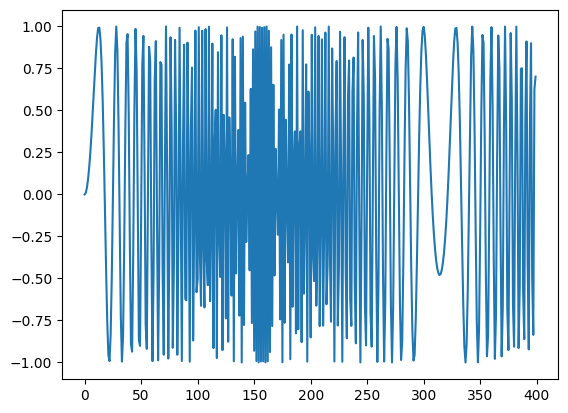

In [ ]:
plt.plot(series)
plt.show()

In [ ]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("x shape :",X.shape , "y shape:",Y.shape)

x shape : (390, 10, 1) y shape: (390, 1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#Define RNN
class RNN(nn.Module):
  def __init__(self ,n_inputs ,n_hidden, n_rnnlayers ,n_outputs):
    super(RNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs
    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True
    )
    self.fc = nn.Linear(self.M,self.K)

  def forward(self,X):
    #initial hidden state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out,_ = self.rnn(X ,(h0,c0))

    #we only want h(t) at the final state
    out = self.fc(out[:,-1,:])
    return out

In [ ]:
#instatiate model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1 ,n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters() ,lr=0.1)

In [ ]:
#make inputs and targets
x_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
x_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
x_train ,y_train = x_train.to(device) ,y_train.to(device)
x_test ,y_test = x_test.to(device) ,y_test.to(device)

In [ ]:
#training

def full_gn(model,
            criterion,
            optimizer,
            x_test,
            y_test,
            x_train,
            y_train,
            epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()

    #forward
    outputs = model(x_train)
    loss = criterion(outputs,y_train)

    #backward
    loss.backward()
    optimizer.step()

    #save loss
    train_losses[it] = loss.item()

    #Test Set
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs,y_test)
    test_losses[it] = test_loss.item()

    if (it+1)%5 ==0:
        print(f"Epoch {it}/{epochs} train loss :{loss:.4f} test loss: {test_loss:.4f}")
  return train_losses,test_losses



In [ ]:
train_losses,test_losses=full_gn(model,criterion,optimizer,x_test,y_test,x_train,y_train)

Epoch 4/200 train loss :0.5136 test loss: 0.5269
Epoch 9/200 train loss :0.4934 test loss: 0.6899
Epoch 14/200 train loss :0.4271 test loss: 0.5574
Epoch 19/200 train loss :0.3406 test loss: 0.5537
Epoch 24/200 train loss :0.2623 test loss: 0.3405
Epoch 29/200 train loss :0.1831 test loss: 0.3340
Epoch 34/200 train loss :0.1311 test loss: 0.2819
Epoch 39/200 train loss :0.0852 test loss: 0.2574
Epoch 44/200 train loss :0.0561 test loss: 0.1978
Epoch 49/200 train loss :0.0370 test loss: 0.1588
Epoch 54/200 train loss :0.0282 test loss: 0.1367
Epoch 59/200 train loss :0.0220 test loss: 0.1400
Epoch 64/200 train loss :0.0162 test loss: 0.1387
Epoch 69/200 train loss :0.0124 test loss: 0.1350
Epoch 74/200 train loss :0.0101 test loss: 0.1370
Epoch 79/200 train loss :0.0088 test loss: 0.1331
Epoch 84/200 train loss :0.0073 test loss: 0.1340
Epoch 89/200 train loss :0.0063 test loss: 0.1318
Epoch 94/200 train loss :0.0056 test loss: 0.1271
Epoch 99/200 train loss :0.0048 test loss: 0.1191
Ep

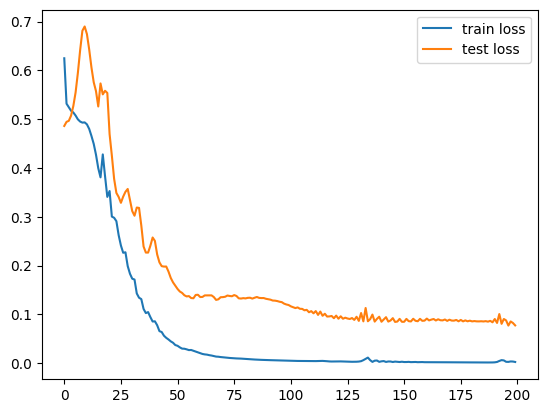

In [ ]:
plt.plot(train_losses,label = 'train loss')
plt.plot(test_losses,label = 'test loss')
plt.legend()
plt.show()

In [ ]:
#one forecast using true target
validation_target = Y[N//2:]
validation_prediction = []
i =0

while len(validation_prediction) < len(validation_target):
  input_ = x_test[i].view(1,T,1)
  p = model(input_)[0,0].item()
  i += 1
  validation_prediction.append(p)


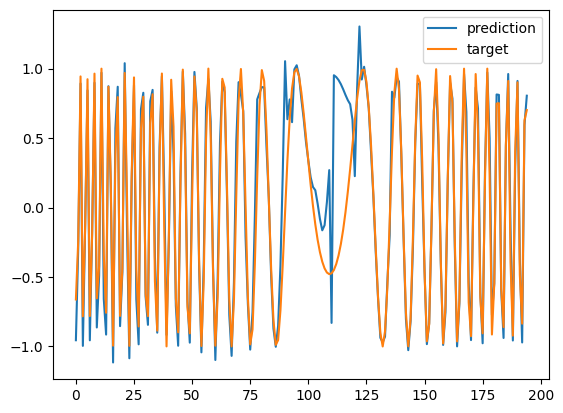

In [ ]:
plt.plot(validation_prediction,label="prediction")
plt.plot(validation_target,label="target")
plt.legend()
plt.show()

In [ ]:
#multiple step forecast using true target
validation_target = Y[N//2:]
validation_prediction = []

# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = x_test[0].view(T)

while len(validation_prediction) < len(validation_target):
  input_ = last_x.view(1,T,1)
  p = model(input_)
  validation_prediction.append(p[0,0].item())

  #make new x
  # last_x = torch.cat((last_x[1:],p))
  last_x = torch.cat((last_x[1:],p[0]))


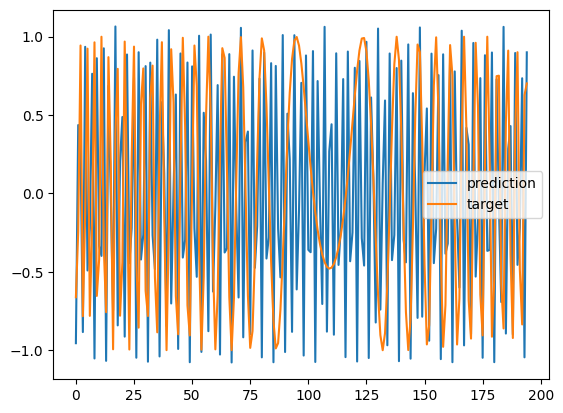

In [ ]:
plt.plot(validation_prediction,label="prediction")
plt.plot(validation_target,label="target")
plt.legend()
plt.show()

In [ ]:
!git remote add origin https://github.com/aygm74/LSTM-Project.git
!git branch -M master
!git push -u origin master

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
